# In this notebook I compute the correlation function of the $D_{ls}$ and  $\textit{pseudo} D_{ls}$. The CAMB correlation function are required in both cases

Firs, I need compute the $C_{ls}$ (really $[Cl*l*(l+1)/2/\pi]*[(10⁶)²] = Dl$) to input in camb correlations function. CMB maps are required in all cases. I will take for full sky map a COM_CMB_IQU-smica_2048_R3.00_hm2 cmb map (https://pla.esac.esa.int/), a cut sky with mask where put 0 in contamination regions and 1 and the others. The correlatión function will be bounded with the dispertion of the synthetic cmb maps made by healpy using camb'Dls

1.$\textbf{I compute and plot the correlations functions of the CMB of  using \Lambda CDM parameters (Planck colaboration 2018).
For this propose I use the python library CAMB(Lewis et al. 2016)}.$

In [1]:
# Importing libraries
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [3]:
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower, correlations
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.5 installed at /home/augusto/anaconda3/envs/CMB/lib/python3.10/site-packages/camb


In [4]:
#Calculate results for specified parameters and return CAMBdata instance for getting results.
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933, mnu=0.06, omk=0.001, tau=0.0561)
pars.InitPower.set_params(As=2.105e-9, ns=0.9665, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [5]:
#calculate results for these parameters
results = camb.get_results(pars)

In [7]:
#Set all CAMB parameters at once, including parameters which are part of the CAMBparams structure, as well as global parameters.
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [8]:
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print(totCL.shape)
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The different CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])

(2551, 4)


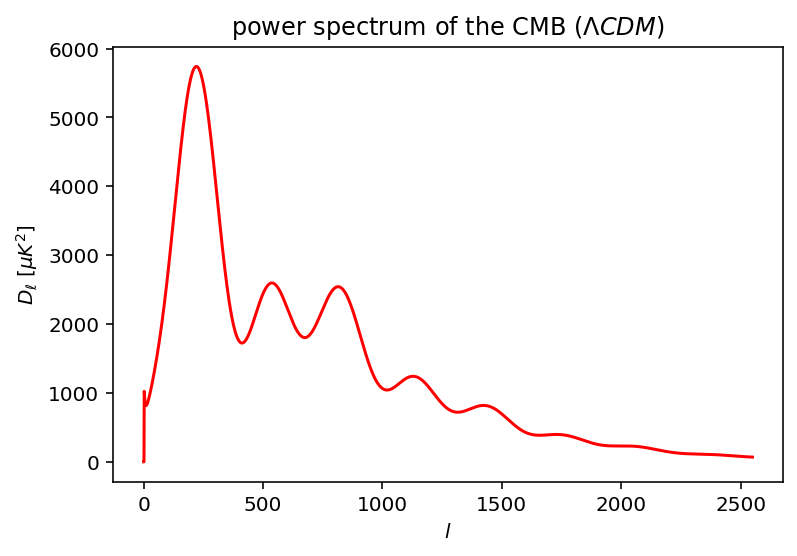

In [16]:
# plot the Dl
plt.plot(ls, totCL[:,0], color='r')
plt.xlabel(r'$l$')
plt.ylabel('$D_\ell~[\mu K^2]$')
plt.title('power spectrum of the CMB ($\Lambda CDM$)')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

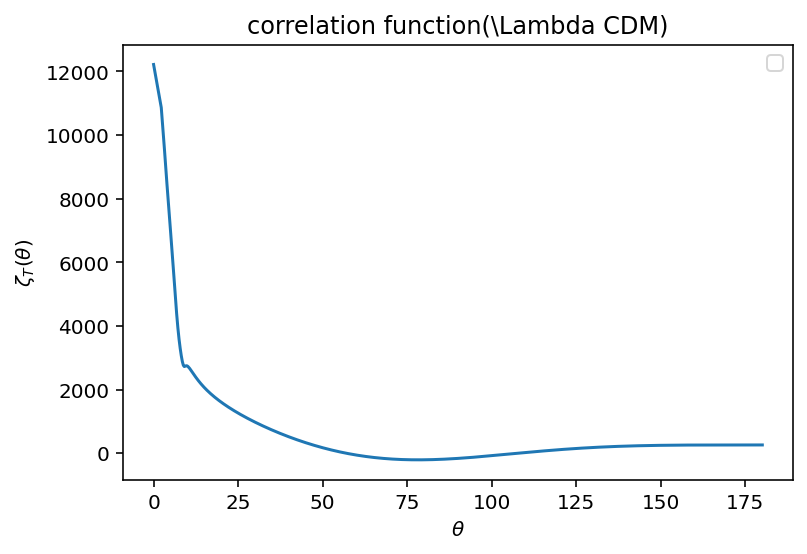

In [37]:
# YI use CAMB to calculate CMB correlation functions
corrs, xvals, weights = correlations.gauss_legendre_correlation(totCL)
xvals=np.linspace(-1,1,2551)
r=np.arccos(xvals)*180/np.pi # sampled theta values in degrees
plt.plot(r, corrs[:,0])
plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.title('correlation function(\Lambda CDM)')
plt.show



2. $\textbf{I  download the COM_CMB_IQU-smica_2048_R3.00_hm2 CMB map (https://pla.esac.esa.int/) and with the help of healpix I will compute.\\
\\the power spectrum of the CMB. Then with CAMB I will compute the correlations function.}$

In [18]:
# import healpy
import healpy as hp

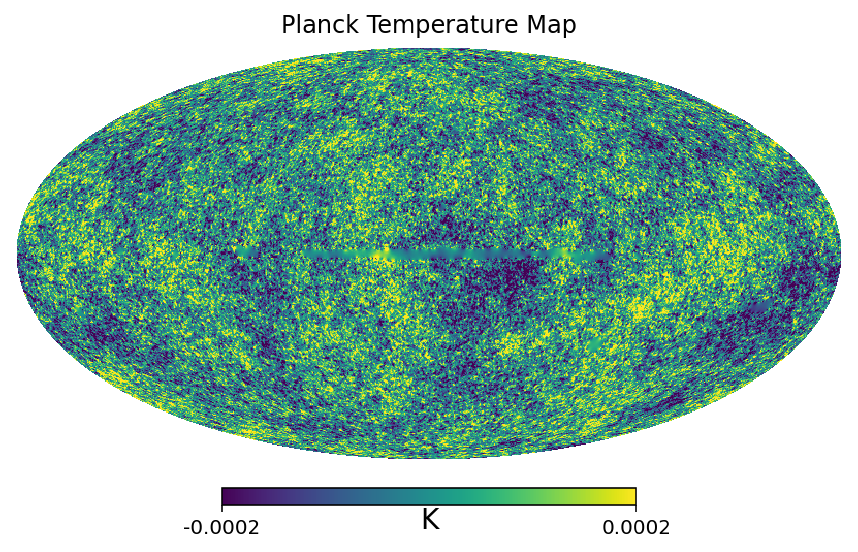

In [19]:
planck_IQU_SMICA=hp.read_map('/home/augusto/Descargas/COM_CMB_IQU-smica_2048_R3.00_hm2.fits')
fig=plt.figure(1)
hp.mollview(planck_IQU_SMICA, min=-0.0002,max=0.0002,
title='Planck Temperature Map',fig=1,unit='K')

Compute the $C_{ls}$ with anafast healpy routine

In [34]:
nside = 2048
lmax=2500
Cl = hp.anafast(planck_IQU_SMICA, lmax= lmax)
l=np.arange(len(Cl))

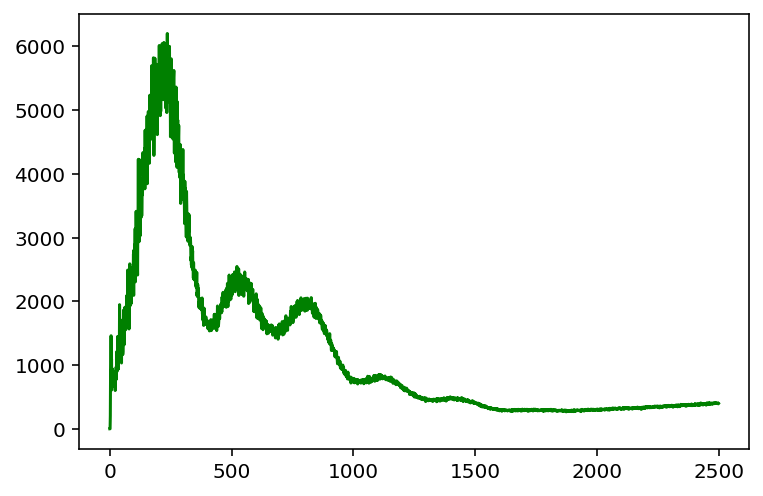

In [35]:
Dl=Cl*l*(l+1)*(1e12)/2/np.pi
plt.plot(l, Dl, color='g')

Compute the correlation function $\zeta_{T1}(\theta)$'

First I must make an arry with dimension four columns

In [31]:
D_l=np.zeros((len(Dl),4))
D_l[:,0]=Dl
D_l.shape

(2501, 4)

In [85]:

corr1, xvals, weights = correlations.gauss_legendre_correlation(D_l) 
xvals1=np.linspace(-1,1,2501)
r1=np.arccos(xvals1)*180/np.pi # sampled theta values in degrees

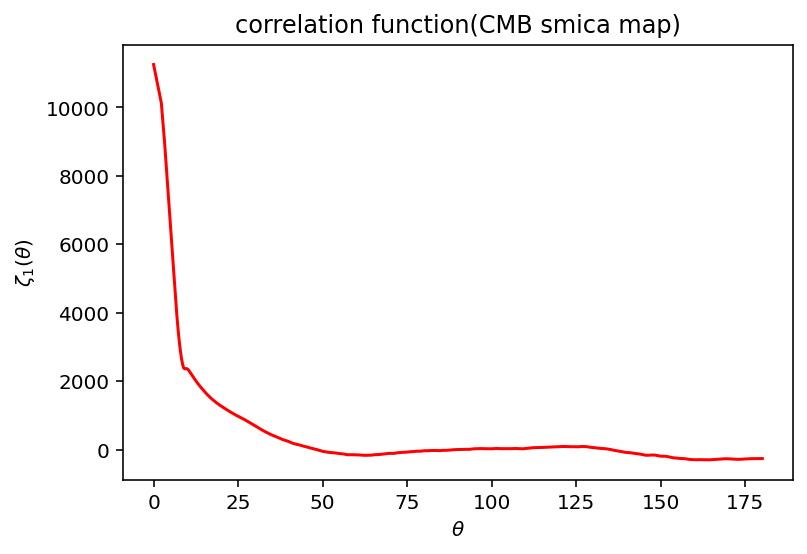

In [86]:
plt.plot(r1, corr1[:,0], color = 'r')
plt.ylabel(r'$\zeta_{1}(\theta)$')
plt.xlabel(r'$\theta$')
#plt.legend()
plt.title('correlation function(CMB smica map)')
plt.show()


3. $\textbf{Because the residual contaminations of the milky way and dust we can't mesaure in that regions. Then we put a mask with 0 and 1. I compute the \textit{pseudo} $C_{ls}$ with namaster python routine.}$

In [41]:
#import pymaster
import pymaster as nmt

We downloaded the COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits -- Temperature confidence mask with fsky = 77.9%.

In [43]:
mask=hp.read_map('/home/augusto/cmblss/data/COM_Mask_CMB-common-Mask-Int_2048_R3.00.fits')

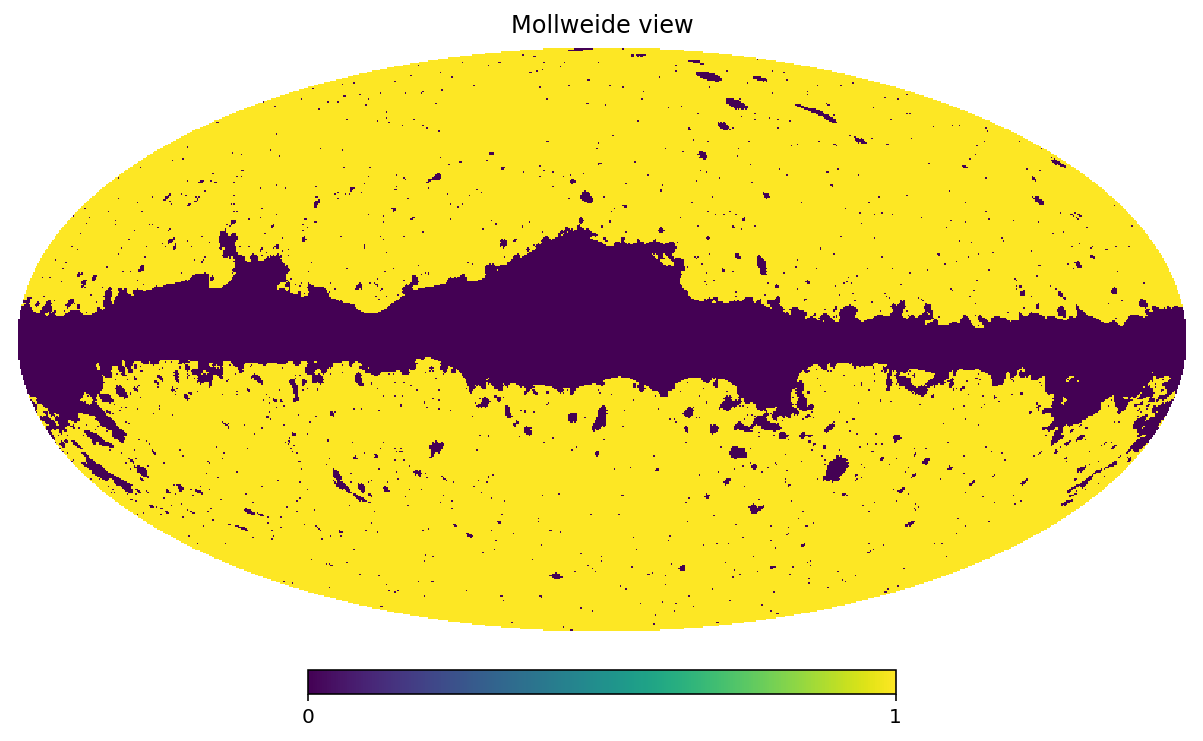

In [44]:
hp.mollview(mask)
plt.show()

In [45]:
# HEALPix resolution parameter used here
nside = 2048

In [65]:
# An NmtField object contains all the information describing the fields to correlate, including their observed maps, masks and contaminant templates.
f_0=nmt.NmtField(mask, [planck_IQU_SMICA])

In [66]:
# Initialize binning scheme with 4 ells per bandpower
# Convenience constructor for HEALPix maps with linear binning.
b = nmt.NmtBin.from_nside_linear(nside, 4)

In [67]:
# Compute MASTER estimator
# spin-0 x spin-0
#Computes the full MASTER estimate of the power spectrum of two fields (f1 and f2). 
cl_00 = nmt.compute_full_master(f_0, f_0, b)

In [72]:
# Shape of the pseudo Cls
cl_00.shape
cl_00[0]


array([1.71563788e-10, 5.87651216e-11, 2.69184966e-11, ...,
       5.27272112e-22, 6.36952861e-22, 9.11504704e-22])

In [69]:
#Returns an array with the effective multipole associated to each bandpower. 
#These are computed as a weighted average of the multipoles within each bandpower.
el = b.get_effective_ells()
el.shape
el



array([3.5000e+00, 7.5000e+00, 1.1500e+01, ..., 6.1315e+03, 6.1355e+03,
       6.1395e+03])

(0.0, 2500.0)

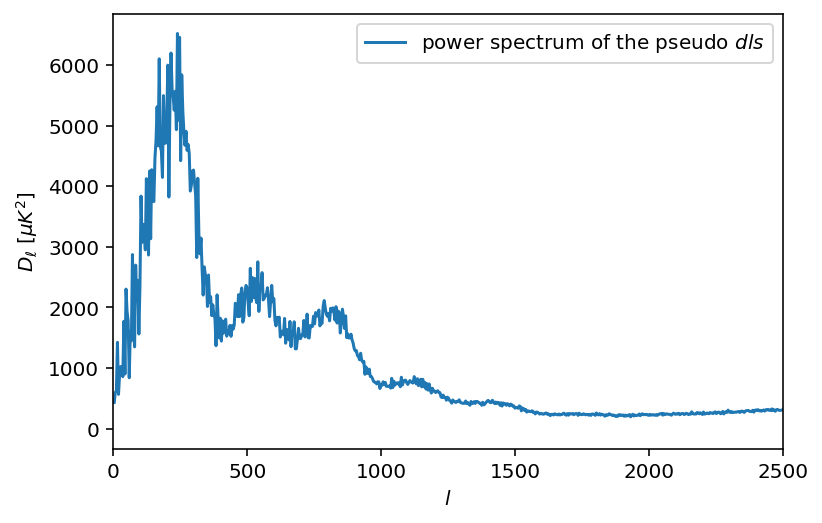

In [75]:
#plot results
dl=cl_00[0]*[(1e6)**(2)]*el*(el+1)/2/np.pi
plt.plot(el,dl, label='power spectrum of the pseudo $dls$')
plt.legend()
plt.xlabel(r'$l$')
plt.ylabel('$D_\ell~[\mu K^2]$')
plt.xlim(0,2500)

$ \textbf{I compute the correlation function $\zeta (\theta)$ of the pseudo $D_l$}

In [76]:
dl.shape

(1535,)

In [77]:
Dl=np.ones((len(dl),4))
Dl[:,0]=dl
Dl.shape

(1535, 4)

In [79]:
corr2, xvals, weights = correlations.gauss_legendre_correlation(Dl) 
xvals2=np.linspace(-1,1,1535)
r2=np.arccos(xvals2)*180/np.pi # sampled theta values in degrees

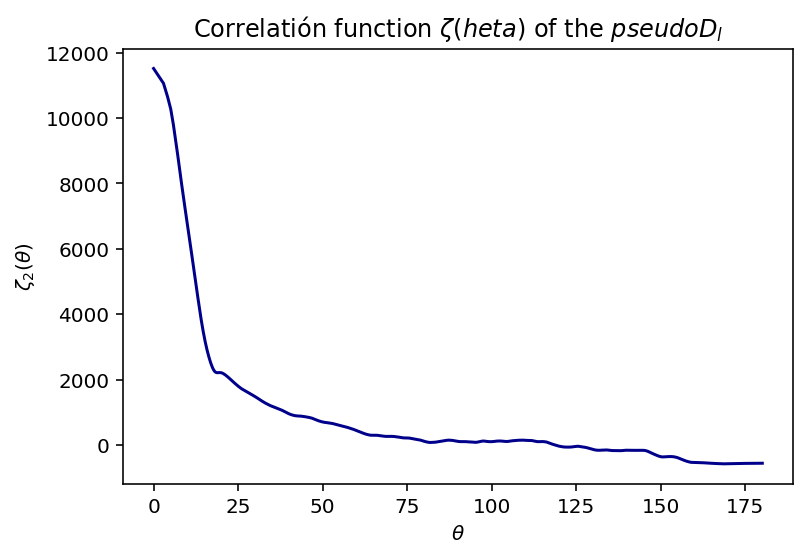

In [82]:
plt.plot(r2, corr2[:,0], color = 'darkblue')
plt.ylabel(r'$\zeta_{2}(\theta)$')
plt.xlabel(r'$\theta$')
plt.title('Correlatión function $\zeta (\theta)$ of the $pseudo D_{l}$')
plt.show()

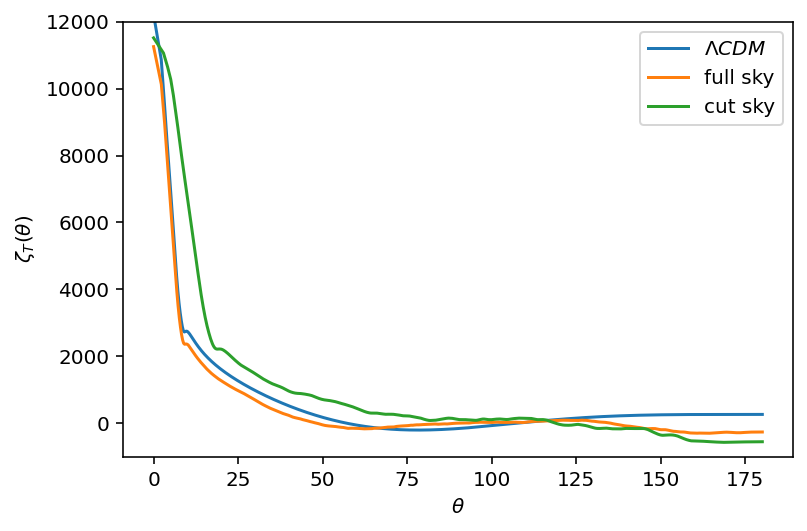

In [90]:
# We put together all correlation function
plt.plot(r, corrs[:,0], label='$\Lambda CDM $')
plt.plot(r1, corr1[:,0], label ='full sky')
plt.plot(r2, corr2[:,0], label = 'cut sky')
plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.ylim(-1000,12000)
plt.legend(loc='best')


In [91]:
# Interpolation of the pseudo Dls
from scipy.interpolate import interp1d

In [92]:
# I define the interpolation with x**3
f=interp1d(el, dl, kind='cubic') 

In [95]:
# I define my news l
lnew=np.linspace(4, 1539, 1535)
#pdl is the interpolated new function 
pdl=f(lnew)
lnew.shape

(1535,)

In [97]:
# p_dl is my new function to use in correlations.gauss_legendre_correlation
p_dl=np.zeros((len(pdl),4))
p_dl[:,0]=pdl
p_dl.shape

(1535, 4)

In [98]:
corr2_1, xvals, weights = correlations.gauss_legendre_correlation(p_dl) 
xvals2_1=np.linspace(-1,1,1535)
r2_1=np.arccos(xvals2)*180/np.pi # sampled theta values in degrees

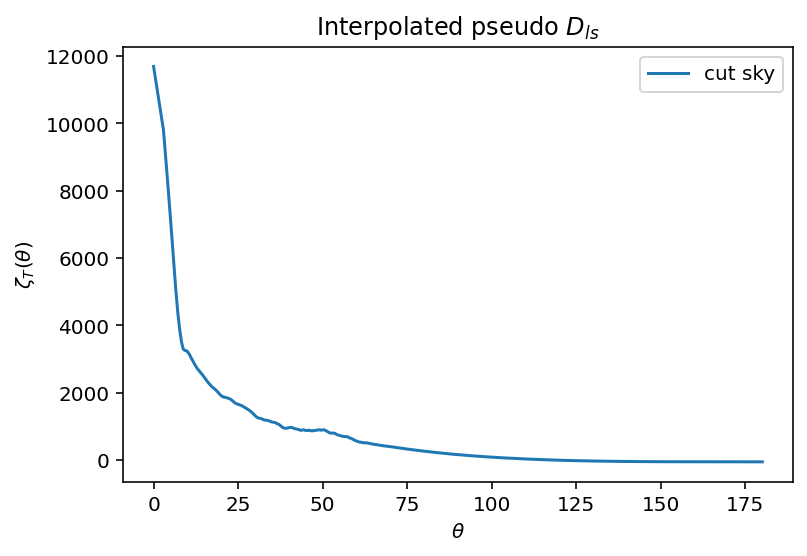

In [99]:
plt.plot(r2_1, corr2_1[:,0], label = 'cut sky')
plt.ylabel(r'$\zeta_{T}(\theta)$')
plt.xlabel(r'$\theta$')
plt.legend(loc='best')
plt.title('Interpolated pseudo $D_{ls}$')
plt.show()

4. $\textbf{In this section we are going to compute the errors. This will be done generating 20 cmb maps with theoretical $D_{ls}$ supplied by $\Lambda CDM$ throughout CAMB and Healpy python routine.}$

In [101]:
# Generating 20 cmb maps
lmax = 2500
nside=2048
mapa_cl_1 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_2 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_3 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_4 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_5 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_6 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_7 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_8 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_9 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_10 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_11 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_12 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_13 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_14 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_15= hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_16 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_17 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_18 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_19 = hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))
mapa_cl_20= hp.sphtfunc.synfast(totCL[:,0], nside=nside, lmax =lmax, fwhm=np.radians(5/60))


In [102]:
# Computing the Dls with anafast healpy library
lmax = 2500
cl1=hp.anafast(mapa_cl_1, lmax=lmax)
cl2=hp.anafast(mapa_cl_2, lmax=lmax)
cl3=hp.anafast(mapa_cl_3, lmax=lmax)
cl4=hp.anafast(mapa_cl_4, lmax=lmax)
cl5=hp.anafast(mapa_cl_5, lmax=lmax)
cl6=hp.anafast(mapa_cl_6, lmax=lmax)
cl7=hp.anafast(mapa_cl_7, lmax=lmax)
cl8=hp.anafast(mapa_cl_8, lmax=lmax)
cl9=hp.anafast(mapa_cl_9, lmax=lmax)
cl10=hp.anafast(mapa_cl_10, lmax=lmax)
cl11=hp.anafast(mapa_cl_11, lmax=lmax)
cl12=hp.anafast(mapa_cl_12, lmax=lmax)
cl13=hp.anafast(mapa_cl_13, lmax=lmax)
cl14=hp.anafast(mapa_cl_14, lmax=lmax)
cl15=hp.anafast(mapa_cl_15, lmax=lmax)
cl16=hp.anafast(mapa_cl_16, lmax=lmax)
cl17=hp.anafast(mapa_cl_17, lmax=lmax)
cl18=hp.anafast(mapa_cl_18, lmax=lmax)
cl19=hp.anafast(mapa_cl_19, lmax=lmax)
cl20=hp.anafast(mapa_cl_20, lmax=lmax)


In [103]:
# We make our functional arrays. All are required to input in in correlations.gauss_legendre_correlation
cl1_ = np.ones((len(cl1),4))
cl2_ =np.ones((len(cl2),4))
cl3_ = np.ones((len(cl3),4))
cl4_ =np.ones((len(cl4),4))
cl5_ = np.ones((len(cl5),4))
cl6_ =np.ones((len(cl6),4))
cl7_ = np.ones((len(cl7),4))
cl8_ =np.ones((len(cl8),4))
cl9_ = np.ones((len(cl9),4))
cl10_ =np.ones((len(cl10),4))
cl11_ = np.ones((len(cl11),4))
cl12_ =np.ones((len(cl12),4))
cl13_ = np.ones((len(cl13),4))
cl14_ =np.ones((len(cl14),4))
cl15_ = np.ones((len(cl15),4))
cl16_ =np.ones((len(cl16),4))
cl17_ = np.ones((len(cl17),4))
cl18_ =np.ones((len(cl18),4))
cl19_ = np.ones((len(cl19),4))
cl20_ =np.ones((len(cl20),4))

cl1_[:,0] = cl1
cl2_[:,0] = cl2
cl3_[:,0] = cl3
cl4_[:,0] = cl4
cl5_[:,0] = cl5
cl6_[:,0] = cl6
cl7_[:,0] = cl7
cl8_[:,0] = cl8
cl9_[:,0] = cl9
cl10_[:,0] = cl10
cl12_[:,0] = cl12
cl13_[:,0] = cl13
cl14_[:,0] = cl14
cl15_[:,0] = cl15
cl16_[:,0] = cl16
cl17_[:,0] = cl17
cl18_[:,0] = cl18
cl19_[:,0] = cl19
cl20_[:,0] = cl20